In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")

# Data exploration

In [4]:
train = pd.read_csv('train.csv')
test =  pd.read_csv('test.csv')

train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


 Age, Cabin have missing values

 Cabin has only 204 obs!!!

 Embarked - very few missings => we can delete them

In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


only 38% survived

target class distribution is not too skeewed - good

mean age below 30, mean fare around 32$

In [3]:
train_num = train[['Age', 'SibSp', 'Parch',  'Fare' ]]
train_cat = train[['Survived', 'Pclass', 'Sex', 'Cabin', 'Embarked']]

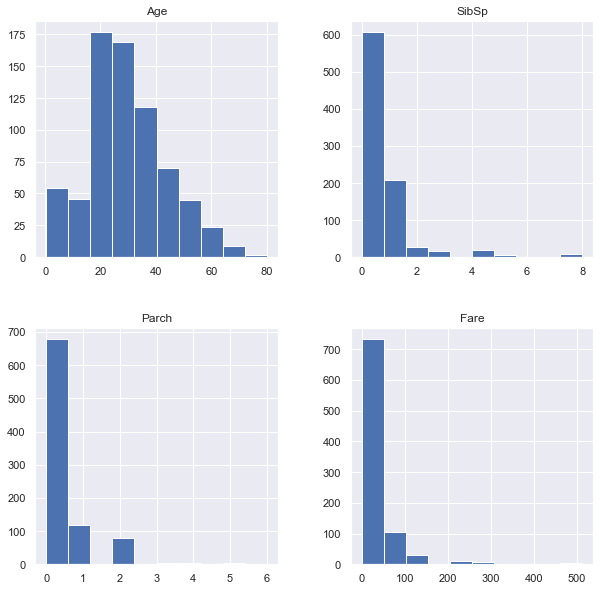

In [6]:
train_num.hist(figsize=(10,10))
plt.show()

 Age - fairly normal distribution, the rest - not

 Fare - large scale and values centered around small val => we might want to normalize it but I'm gonna later scale all data anyway

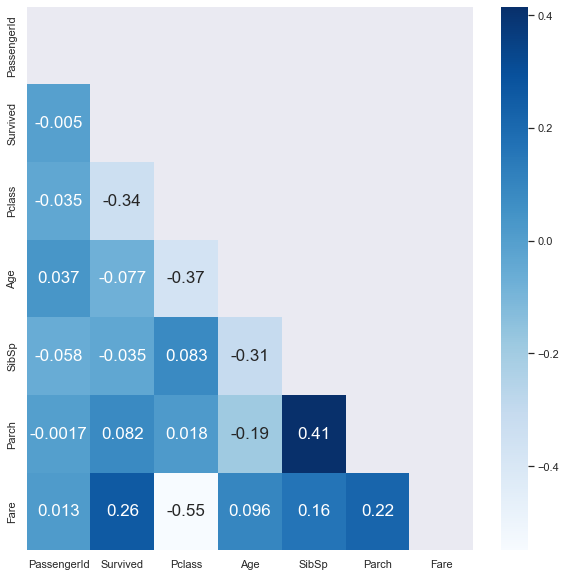

In [5]:
cor = train.corr()
plt.figure(figsize = (10,10))
sns.heatmap(cor, mask=np.triu(cor),cmap='Blues', annot=True, annot_kws={"fontsize":17})
plt.show()


 Parch + SibSp - could be transformed into one variable eq. family

 Age could be imputed with a median based on Pclass

In [8]:
pd.pivot_table(train, index='Survived', values=list(train_num.columns))

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


survivors had higher fare mean and were younger

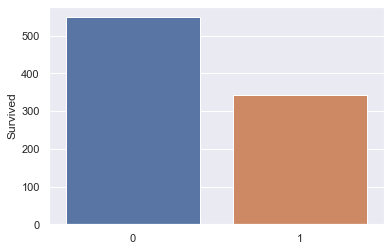

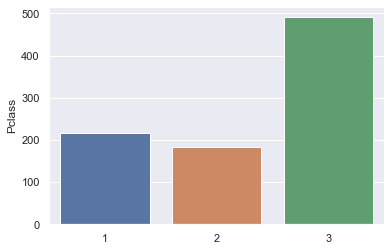

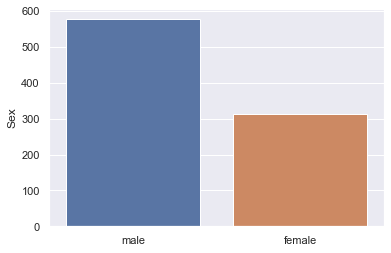

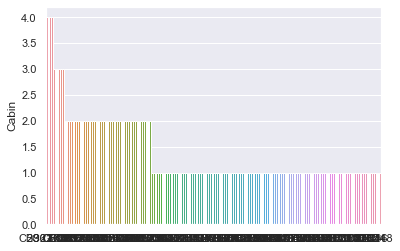

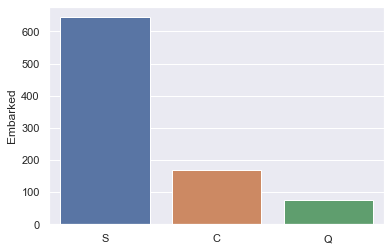

In [9]:
for var in train_cat.columns:
    sns.barplot(x=train_cat[var].value_counts().index, y=train_cat[var].value_counts())
    plt.show()


Exploring relationship to target variable:

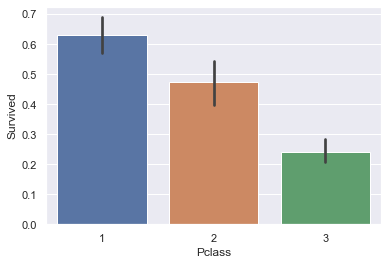

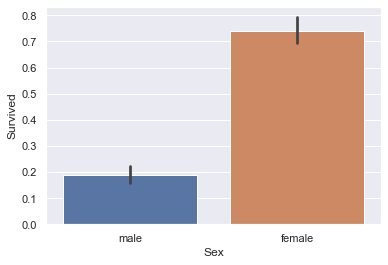

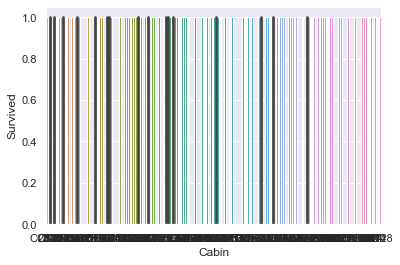

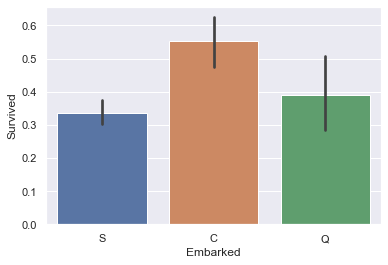

In [17]:
for var in train_cat.columns[1:]:
    sns.barplot(x=train_cat[var], y=train_cat['Survived'])
    plt.show()


 females and rich were more likely to survive

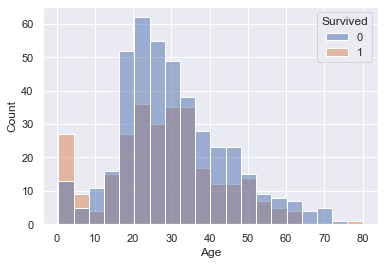

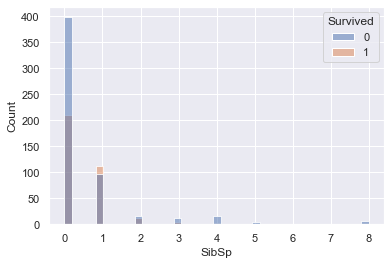

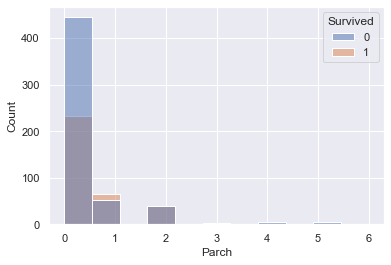

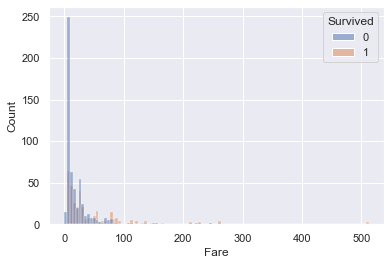

In [22]:
for var in train_num:
    sns.histplot(x=train_num[var], hue=train['Survived'])
    plt.show()

# Feature engineering:

Age:

In [24]:
train.groupby(['Pclass']).median()['Age'], train.groupby(['Sex']).median()['Age']

(Pclass
 1    37.0
 2    29.0
 3    24.0
 Name: Age, dtype: float64,
 Sex
 female    27.0
 male      29.0
 Name: Age, dtype: float64)

In [4]:
train.groupby(['Pclass', 'Sex']).median()['Age']

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

Age data imputation based on median groupped by Pclass and Sex:

In [25]:
train['Age'] = train['Age'].fillna(train.groupby(['Pclass','Sex'])['Age'].transform('median'))

Cabin:

First letter of cabin is the deck.

In [6]:
train['Deck'] = train['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'Mis')

<AxesSubplot:xlabel='Deck', ylabel='Survived'>

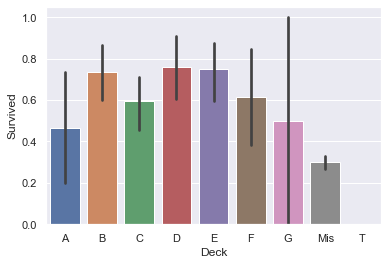

In [36]:
train = train.sort_values(['Deck']).reset_index(drop=True)
sns.barplot(x='Deck', y='Survived', data=train)

In [40]:
train[["Deck", "Survived"]].groupby(['Deck']).mean()

,Survived
Deck,
A,0.466667
B,0.733333
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
Mis,0.299854
T,0.000000


In [7]:
test['Deck'] = test['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'Mis')
print(train['Deck'].unique())
print(test['Deck'].unique())
print(train[train['Deck']=='T'])

['Mis' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
['Mis' 'B' 'E' 'A' 'C' 'D' 'F' 'G']
     PassengerId  Survived  Pclass                          Name   Sex   Age  \
339          340         0       1  Blackwell, Mr. Stephen Weart  male  45.0   

     SibSp  Parch  Ticket  Fare Cabin Embarked Deck  
339      0      0  113784  35.5     T        S    T  


In test set we don't have any observations with Deck = T, and in train set there's only one =><br>let's classify T as Mis

In [15]:
train['Deck'] = train['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'Mis')
train['Deck'] = train['Deck'].replace(['T'], 'Mis')
train['Deck'].unique()

array(['Mis', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

SibSp and Parch:

In [39]:
train['Family'] = train['SibSp'] + train['Parch']
train[["Family", "Survived"]].groupby(['Family']).mean()

,Survived
Family,
0,0.300935
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000
